In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from scipy import sparse
from pathlib import Path
import scanpy as sc
import copy
import umap
# import rnanorm

In [87]:
samples = [151507, 151669, 151673]

def load_sparse_mat(filtered_filename, sample_number):
    with h5py.File(filtered_filename, 'r') as f:
        data = np.array(f['matrix']['data'])
        filtered_barcodes = np.array(f['matrix']['barcodes']).astype('U13')  # b'AAACAAGTATCTCCCA-1'  4992 columns
        _id = np.array(f['matrix']['features']['id']).astype('U13')   #  b'ENSG00000275063' 33538 rows
        name = np.array(f['matrix']['features']['name']).astype('U13')   # Gene name b'AL627309.3' 33538 rows
        indices = np.array(f['matrix']['indices'])
        indptr = np.array(f['matrix']['indptr'])
        shape = np.array(f['matrix']['shape'])
        
    barcodes = pd.DataFrame(filtered_barcodes)
    barcodes['in_filtered'] = barcodes[0].isin(filtered_barcodes).astype('int')
    m = sparse.csr_matrix((data, indices, indptr), shape=(shape[1], shape[0]))
    index = [barcodes[0].astype('str').to_list(), 
             [str(sample_number)]*len(barcodes)]
    columns = [name, _id]
    return m.toarray()

def load_data():
    col_metadata = pd.read_csv(r'../data/column_metadata.csv', index_col=0)
    row_metadata = pd.read_csv(r'../data/row_metadata.csv', index_col=0)
    filtfiles = [x for x in Path(r'..\data').glob('*filt*.h5')]
    filtfiles = [x for x in filtfiles if (str(samples[0]) in str(x)) or \
                 (str(samples[1]) in str(x)) or (str(samples[2]) in str(x))]
    dfs = []
    for filtered_file in filtfiles:
        sample_number = filtered_file.stem.split('_')[0]
        df = load_sparse_mat(filtered_filename=filtered_file, 
                             sample_number=sample_number)
        dfs.append(df)
    cdf = np.concatenate(dfs)
    adata_master = sc.AnnData(
        X=cdf,   
        obs=col_metadata.loc[col_metadata.sample_name.isin([151507, 151669, 151673])],     
        var=row_metadata)  # obs = rows      var = cols
    del cdf
    del dfs
    return adata_master
adata_master = load_data()

# Filter genes with counts less than 100
high_count_genes = adata_master.X.sum(axis=0) > 100
adata_master = adata_master[:, high_count_genes]

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [108]:
normtot = copy.copy(adata_master)
sc.pp.normalize_total(normtot, exclude_highly_expressed=True, inplace=True)
normtot = normtot.T
normtot

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 13585 × 11526
    obs: 'source', 'type', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'gene_search', 'is_top_hvg'
    var: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'Spa

In [90]:
dino = pd.read_csv(r'..\data\dino_norm.csv', index_col=0)
dino = sc.AnnData(dino.values, obs=normtot.obs, var=normtot.var)

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  


In [107]:
dino

AnnData object with n_obs × n_vars = 13585 × 11526
    obs: 'source', 'type', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'gene_search', 'is_top_hvg', 'umap1', 'umap2'
    var: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', '

In [50]:
sctransform = pd.read_csv(r'../data/SCT_norm.csv', index_col=0)
sctransform

,AAACAACGAATAGTTC-1,AAACAAGTATCTCCCA-1,AAACAATCTACTAGCA-1,AAACACCAATAACTGC-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACAGTGTTCCTGGG-1,AAACATTTCCCGGATT-1,AAACCACTACACAGAT-1,AAACCCGAACGAAATC-1,...,TTGTGTATGCCACCAA-1.2,TTGTGTTTCCCGAAAG-1.2,TTGTTAGCAAATTCGA-1.2,TTGTTCAGTGTGCTAC-1.2,TTGTTGTGTGTCAAGA-1.2,TTGTTTCACATCCAGG-1.2,TTGTTTCATTAGTCTA-1.2,TTGTTTCCATACAACT-1.2,TTGTTTGTATTACACG-1,TTGTTTGTGTAAATTC-1.2
ENSG00000237491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000187961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000187608,1.098612,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,...,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198727,2.944439,3.688879,3.526361,3.044522,3.737670,3.465736,3.526361,3.555348,3.663562,3.871201,...,3.218876,3.610918,3.295837,3.401197,3.637586,2.995732,3.433987,3.761200,3.401197,3.610918
ENSG00000277400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000273748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000278817,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [51]:
sct = sc.AnnData(sctransform.values, obs=normtot.obs, var=normtot.var)

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [54]:
sct.var.columns

Index(['barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow',
       'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene',
       'subject', 'position', 'replicate', 'subject_position', 'discard',
       'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6',
       'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11',
       'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15',
       'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19',
       'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23',
       'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27',
       'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess',
       'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM',
       'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA',
       'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP',
       'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP',
    

## Try UMAP clustering

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [59]:
penguins = pd.read_csv("https://github.com/allisonhorst/palmerpenguins/raw/5b5891f01b52ae26ad8cb9755ec93672f49328a8/data/penguins_size.csv")
penguins.head()
penguins = penguins.dropna()
penguins.species_short.value_counts()
penguins

,species_short,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [100]:
normtot[:, normtot.var['sample_name'] == 151507].X.T.shape

(4226, 13585)

In [101]:
umap_results = {}

for sample in samples:
    umap_results[sample] = {}
    for df, name in [(normtot, 'normtot'), (sct, 'sct'), (dino, 'dino')]:
        df = df[:, df.var['sample_name'] == sample].X.T  # filter data from one sample and transpose into right shape
        reducer = umap.UMAP(metric='correlation', learning_rate=10, low_memory=False, random_state=1)
        embedding = reducer.fit_transform(df)
        umap_results[sample][name] = embedding

In [104]:
df.var.loc[df.var['sample_name'] == sample]

,barcode,sample_name,tissue,row,col,imagerow,imagecol,Cluster,height,width,...,markers_PCA_spatial,SpatialDE_UMAP_spatial,SpatialDE_pool_UMAP_spatial,HVG_UMAP_spatial,pseudobulk_UMAP_spatial,markers_UMAP_spatial,spatialLIBD,ManualAnnotation,umap1,umap2
AAACAAGTATCTCCCA-1.8,AAACAAGTATCTCCCA-1,151673,1,50,102,381.098123,440.639079,7,600,600,...,1,7,1,1,2,1,L3,NaN,4.253564,2.038240
AAACAATCTACTAGCA-1.3,AAACAATCTACTAGCA-1,151673,1,3,43,126.327637,259.630972,4,600,600,...,3,2,1,4,2,3,L1,NaN,7.037365,-0.061789
AAACACCAATAACTGC-1.8,AAACACCAATAACTGC-1,151673,1,59,19,427.767792,183.078314,8,600,600,...,3,5,7,5,3,2,WM,NaN,11.189465,1.902408
AAACAGAGCGACTCCT-1.7,AAACAGAGCGACTCCT-1,151673,1,14,94,186.813688,417.236738,6,600,600,...,2,3,4,2,1,1,L3,NaN,-1.192821,7.647009
AAACAGCTTTCAGAAG-1.7,AAACAGCTTTCAGAAG-1,151673,1,43,9,341.269139,152.700275,3,600,600,...,1,3,3,8,4,4,L5,NaN,5.035595,0.505905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1.8,TTGTTTCACATCCAGG-1,151673,1,58,42,422.862301,254.410450,8,600,600,...,8,5,7,5,7,5,WM,NaN,11.631557,1.244312
TTGTTTCATTAGTCTA-1.8,TTGTTTCATTAGTCTA-1,151673,1,60,30,433.393354,217.146722,8,600,600,...,8,5,7,1,1,4,WM,NaN,10.996490,1.506553
TTGTTTCCATACAACT-1.8,TTGTTTCCATACAACT-1,151673,1,45,27,352.430255,208.415849,6,600,600,...,3,1,3,3,3,3,L6,NaN,9.310563,2.408251
TTGTTTGTATTACACG-1.4,TTGTTTGTATTACACG-1,151673,1,73,41,503.735391,250.720081,6,600,600,...,3,1,3,4,1,3,WM,NaN,9.863804,1.438872


C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

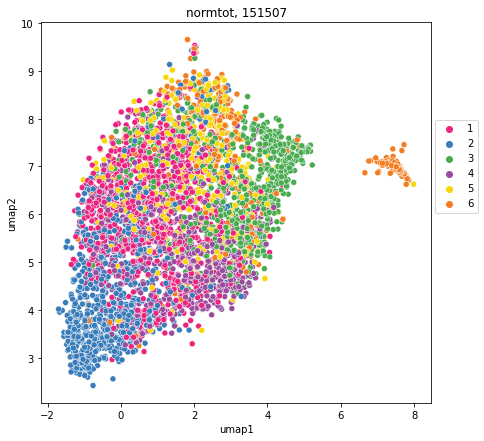

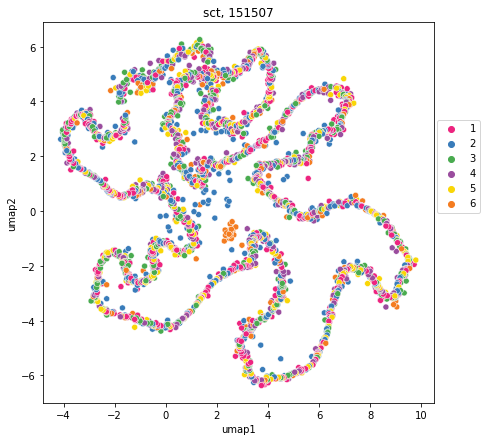

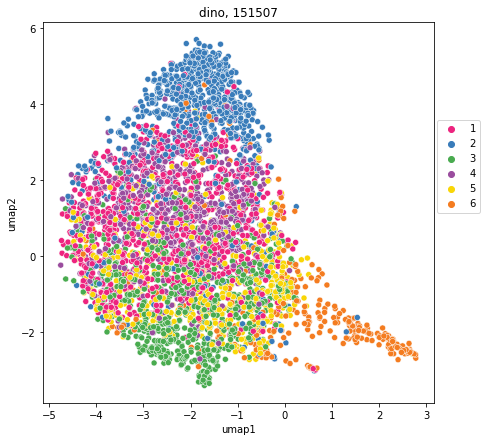

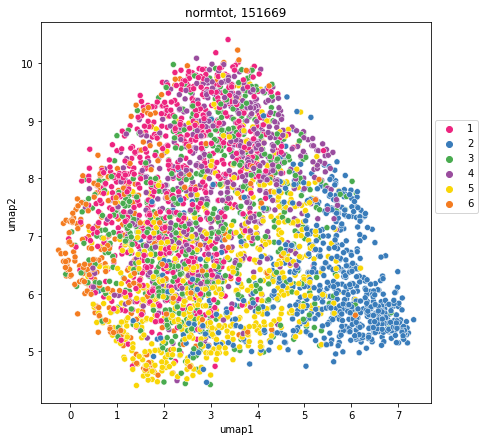

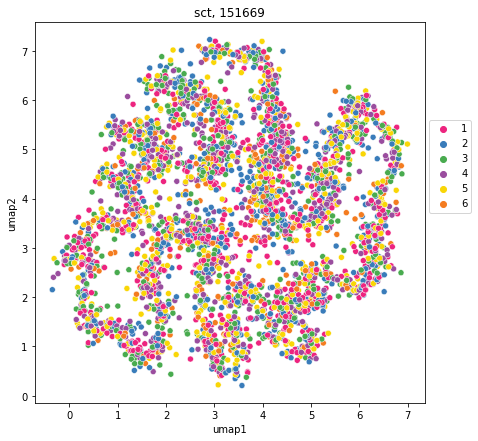

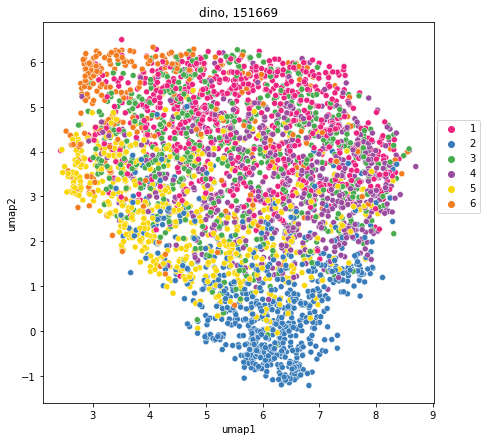

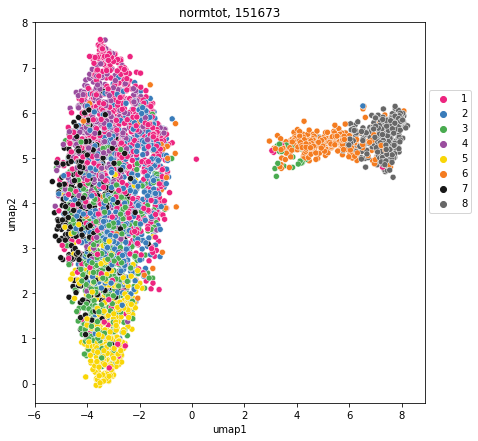

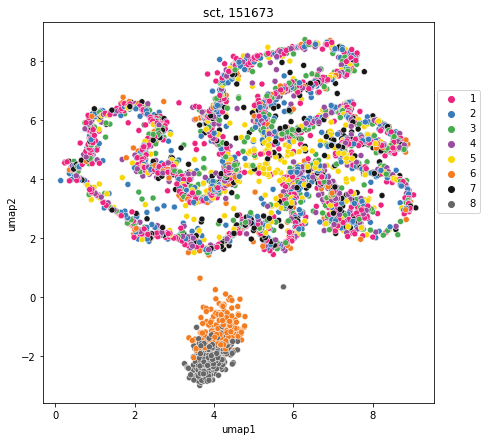

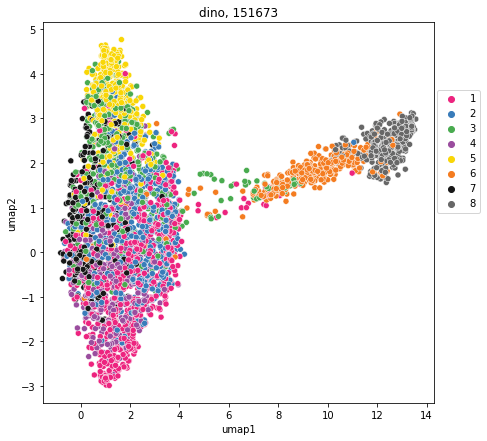

<Figure size 432x288 with 0 Axes>

In [106]:
for sample in samples:
    for df, name in [(normtot, 'normtot'), (sct, 'sct'), (dino, 'dino')]:
#         df = df[:, df.var['sample_name'] == sample].X.T
        result = df.var.loc[df.var['sample_name'] == sample]
        result[['umap1', 'umap2']] = umap_results[sample][name]
        sns.scatterplot(data=result, x='umap1', y='umap2', hue='Cluster', palette=palette)
        plt.title(f'{name}, {sample}')
        plt.legend(loc=(1.01, 0.5))
        plt.gcf().set_size_inches(7, 7)
        plt.figure()

In [78]:
reducer = umap.UMAP()

In [79]:
embedding = reducer.fit_transform(normtot.X.T)

In [85]:
palette = {
    '1': "#ED247F", 1: "#ED247F",
    '2': '#397CBA', 2: '#397CBA',
    '3': '#49AB4F', 3: '#49AB4F',
    '4': '#9A4D9E', 4: '#9A4D9E',
    '5': '#F9D606', 5: '#F9D606',
    '6': '#F47C20', 6: '#F47C20',
    '7': '#171717', 7: '#171717',
    '8': '#676767', 8: '#676767',
}

In [82]:
ud = normtot.var
ud[['umap1', 'umap2']] = embedding
ud

,barcode,sample_name,tissue,row,col,imagerow,imagecol,Cluster,height,width,...,markers_PCA_spatial,SpatialDE_UMAP_spatial,SpatialDE_pool_UMAP_spatial,HVG_UMAP_spatial,pseudobulk_UMAP_spatial,markers_UMAP_spatial,spatialLIBD,ManualAnnotation,umap1,umap2
AAACAACGAATAGTTC-1,AAACAACGAATAGTTC-1,151507,1,0,16,113.141318,147.434749,6,600,600,...,3,1,1,1,1,1,L1,NaN,8.219683,-0.365805
AAACAAGTATCTCCCA-1,AAACAAGTATCTCCCA-1,151507,1,50,102,383.438357,413.051319,3,600,600,...,1,2,2,1,2,1,L3,NaN,5.713300,2.279934
AAACAATCTACTAGCA-1,AAACAATCTACTAGCA-1,151507,1,3,43,129.522957,231.008109,2,600,600,...,7,2,1,4,1,6,L1,NaN,1.148998,5.876933
AAACACCAATAACTGC-1,AAACACCAATAACTGC-1,151507,1,59,19,431.188134,155.805586,5,600,600,...,7,7,8,7,8,1,WM,NaN,11.666046,1.189221
AAACAGCTTTCAGAAG-1,AAACAGCTTTCAGAAG-1,151507,1,43,9,344.869499,125.067511,1,600,600,...,2,8,2,8,1,1,L6,NaN,4.092410,2.798816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1.8,TTGTTTCACATCCAGG-1,151673,1,58,42,422.862301,254.410450,8,600,600,...,8,5,7,5,7,5,WM,NaN,11.631557,1.244312
TTGTTTCATTAGTCTA-1.8,TTGTTTCATTAGTCTA-1,151673,1,60,30,433.393354,217.146722,8,600,600,...,8,5,7,1,1,4,WM,NaN,10.996490,1.506553
TTGTTTCCATACAACT-1.8,TTGTTTCCATACAACT-1,151673,1,45,27,352.430255,208.415849,6,600,600,...,3,1,3,3,3,3,L6,NaN,9.310563,2.408251
TTGTTTGTATTACACG-1.4,TTGTTTGTATTACACG-1,151673,1,73,41,503.735391,250.720081,6,600,600,...,3,1,3,4,1,3,WM,NaN,9.863804,1.438872


<AxesSubplot:xlabel='umap1', ylabel='umap2'>

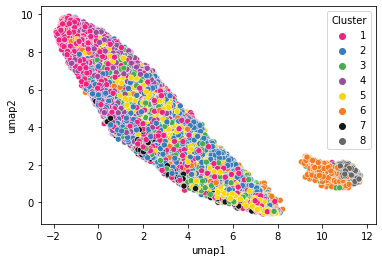

In [86]:
sns.scatterplot(data=ud, x='umap1', y='umap2', hue='Cluster', palette=palette)

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not {'1': '#ED247F', '2': '#397CBA', '3': '#49AB4F', '4': '#9A4D9E', '5': '#F9D606', '6': '#F47C20', '7': '#171717', '8': '#676767'}

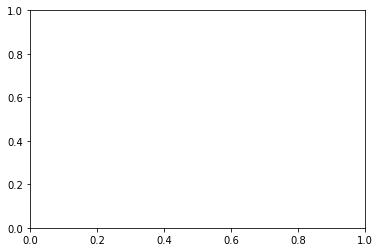

In [68]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})],
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)